# MNIST - Generative Adversarial Network

In [18]:
from __future__ import division, print_function, absolute_import
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [19]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [20]:
#Training Params
learning_rate = 0.0002
batch_size = 128
num_steps = 70000

In [21]:
#Network Params
image_dim = 784
gen_hidden_dim = 256
disc_hidden_dim = 256
noise_dim = 100

In [22]:
#Custom Initializer
def xav(shape):
    return tf.random_normal(shape=shape,stddev=1./tf.sqrt(shape[0]/2.))

In [23]:
#Store layers weight and biases
weights = {
    'gen_hidden_1' :tf.Variable(xav([noise_dim,gen_hidden_dim])),
    'gen_out' : tf.Variable(xav([gen_hidden_dim,image_dim])),
    'disc_hidden_1' : tf.Variable(xav([image_dim,disc_hidden_dim])),
    'disc_out' : tf.Variable(xav([disc_hidden_dim,1]))
}

biases = {
    'gen_hidden_1' : tf.Variable(tf.zeros([gen_hidden_dim])),
    'gen_out' : tf.Variable(tf.zeros([image_dim])),
    'disc_hidden_1' : tf.Variable(tf.zeros([disc_hidden_dim])),
    'disc_out' : tf.Variable(tf.zeros([1]))
}

In [24]:
#Generator
def generator(x):
    hid_layer = tf.add(tf.matmul(x,weights['gen_hidden_1']),biases['gen_hidden_1'])
    hid_layer = tf.nn.relu(hid_layer)
    
    out_layer = tf.add(tf.matmul(hid_layer,weights['gen_out']),biases['gen_out'])
    out_layer = tf.nn.sigmoid(out_layer)
    
    return out_layer

In [25]:
#Discriminator
def discriminator(x):
    hid_layer = tf.add(tf.matmul(x,weights['disc_hidden_1']),biases['disc_hidden_1'])
    hid_layer = tf.nn.relu(hid_layer)
    
    out_layer = tf.add(tf.matmul(hid_layer,weights['disc_out']),biases['disc_out'])
    out_layer = tf.nn.sigmoid(out_layer)
    
    return out_layer

In [29]:
#Building Network

#Network inputs
gen_input = tf.placeholder(tf.float32,shape=[None,noise_dim],name='input_noise')
disc_input = tf.placeholder(tf.float32,shape=[None,image_dim],name='disc_input')

#Build Gen Network
gen_output = generator(gen_input)

#Build 2 Disc Networks(one from noise input and one from generator samples)
disc_real = discriminator(disc_input)
disc_fake = discriminator(gen_output)

#Build Loss
gen_loss = -tf.reduce_mean(tf.log(disc_fake))
disc_loss = -tf.reduce_mean(tf.log(disc_real)  + tf.log(1. - disc_fake))

#Build Optimizers
optimizer_gen = tf.train.AdamOptimizer(learning_rate=learning_rate)
optimizer_disc = tf.train.AdamOptimizer(learning_rate=learning_rate)

#VARIABLES
gen_vars = [weights['gen_hidden_1'],weights['gen_out'],
           biases['gen_hidden_1'],biases['gen_out']]
disc_vars = [weights['disc_hidden_1'],weights['disc_out'],
           biases['disc_hidden_1'],biases['disc_out']]

#Training ops
train_gen = optimizer_gen.minimize(gen_loss,var_list=gen_vars)
train_disc = optimizer_disc.minimize(disc_loss,var_list=disc_vars)

init = tf.global_variables_initializer()

In [30]:
#Start Training
sess = tf.Session()
sess.run(init)
for i in range(1,num_steps+1):
    batch_x, _ = mnist.train.next_batch(batch_size)
    z = np.random.uniform(-1.,1.,size=[batch_size,noise_dim])

    feed_dict = {disc_input:batch_x,gen_input:z}
    _,_,gl,dl = sess.run([train_gen,train_disc,gen_loss,disc_loss],feed_dict=feed_dict)
    if i%2000 == 0 or i == 1:
        print('Step %i: Generator Loss: %f, Discriminator Loss: %f' %(i,gl,dl))    

Step 1: Generator Loss: 1.210587, Discriminator Loss: 1.236065
Step 2000: Generator Loss: 4.695496, Discriminator Loss: 0.035461
Step 4000: Generator Loss: 4.490327, Discriminator Loss: 0.040897
Step 6000: Generator Loss: 4.175813, Discriminator Loss: 0.123997
Step 8000: Generator Loss: 4.636317, Discriminator Loss: 0.114911
Step 10000: Generator Loss: 3.550632, Discriminator Loss: 0.154316
Step 12000: Generator Loss: 3.194623, Discriminator Loss: 0.253326
Step 14000: Generator Loss: 4.805747, Discriminator Loss: 0.194194
Step 16000: Generator Loss: 3.901429, Discriminator Loss: 0.209401
Step 18000: Generator Loss: 3.324996, Discriminator Loss: 0.246867
Step 20000: Generator Loss: 3.528189, Discriminator Loss: 0.338830
Step 22000: Generator Loss: 3.614625, Discriminator Loss: 0.232057
Step 24000: Generator Loss: 3.660890, Discriminator Loss: 0.309236
Step 26000: Generator Loss: 3.354062, Discriminator Loss: 0.266566
Step 28000: Generator Loss: 3.893543, Discriminator Loss: 0.367374
Ste

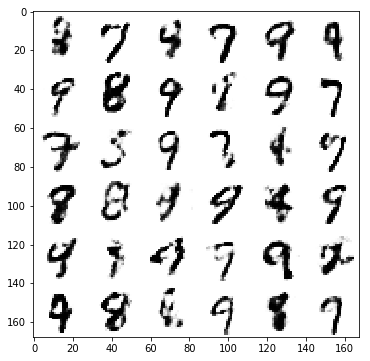

In [35]:
# Testing
n = 6
canvas = np.empty((28 * n, 28 * n))
for i in range(n):
    z = np.random.uniform(-1., 1., size=[n, noise_dim])
    g = sess.run(gen_output, feed_dict={gen_input: z})
    g = -1 * (g - 1)
    for j in range(n):
        canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])

plt.figure(figsize=(n, n))
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show()